In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


combined_df= pd.read_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv')

In [5]:
combined_df.head()

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock
0,2010-05-03 09:30:00-04:00,58.960000,6.0,35.0,59.065455,11.0,2.0,59.030000,1200.0,2010-05-03,NaN,NaN,NaN,DLR
1,2010-05-03 09:32:00-04:00,59.028846,5.0,26.0,59.143333,12.0,2.0,59.103284,1218.0,2010-05-03,2.0,0.001241,0.000621,DLR
2,2010-05-03 09:33:00-04:00,59.304444,4.0,9.0,59.555000,10.0,3.0,59.518000,500.0,2010-05-03,1.0,0.007017,0.007017,DLR
3,2010-05-03 09:34:00-04:00,59.560000,1.0,2.0,59.660000,4.0,2.0,59.560000,400.0,2010-05-03,1.0,0.000706,0.000706,DLR
4,2010-05-03 09:35:00-04:00,59.570000,1.0,1.0,59.710000,5.0,5.0,59.680000,100.0,2010-05-03,1.0,0.002015,0.002015,DLR


In [ ]:
# Include bid and ask prices in the features
features = ['weighted_trade_price', 'return', 'total_trade_volume', 
            'weighted_bid_price', 'weighted_ask_price']

# Fill NaN values to avoid clustering issues
data_filled = data[features].fillna(0)

# Scale the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filled)

# Adjust window size to 30 minutes
window_size = 30  # Each tick represents 1 minute, so 30 ticks = 30 minutes

# Create 30-minute time windows
time_windows = []
for i in range(0, len(data_scaled) - window_size + 1):
    window = data_scaled[i:i + window_size]
    time_windows.append(window)

# Convert to NumPy array for clustering
time_windows = np.array(time_windows)

# Use an alternative clustering method (e.g., KMeans on flattened windows)
from sklearn.cluster import KMeans

# Flatten each time window for clustering
time_windows_flat = time_windows.reshape(time_windows.shape[0], -1)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(time_windows_flat)

# Visualize Cluster Centroids (reshape back for visualization)
centroids = kmeans.cluster_centers_.reshape(-1, window_size, len(features))

plt.figure(figsize=(12, 6))
for cluster_id in range(5):
    plt.plot(range(window_size), centroids[cluster_id, :, 0], label=f"Cluster {cluster_id} (Trade Price)")
plt.legend()
plt.title("Cluster Centroids for 30-Minute Windows (Weighted Trade Price)")
plt.xlabel("Time (Minutes)")
plt.ylabel("Normalized Feature Value")
plt.show()


In [8]:
combined_df.head()

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock
0,2010-05-03 09:30:00-04:00,58.960000,6.0,35.0,59.065455,11.0,2.0,59.030000,1200.0,2010-05-03,NaN,NaN,NaN,DLR
1,2010-05-03 09:32:00-04:00,59.028846,5.0,26.0,59.143333,12.0,2.0,59.103284,1218.0,2010-05-03,2.0,0.001241,0.000621,DLR
2,2010-05-03 09:33:00-04:00,59.304444,4.0,9.0,59.555000,10.0,3.0,59.518000,500.0,2010-05-03,1.0,0.007017,0.007017,DLR
3,2010-05-03 09:34:00-04:00,59.560000,1.0,2.0,59.660000,4.0,2.0,59.560000,400.0,2010-05-03,1.0,0.000706,0.000706,DLR
4,2010-05-03 09:35:00-04:00,59.570000,1.0,1.0,59.710000,5.0,5.0,59.680000,100.0,2010-05-03,1.0,0.002015,0.002015,DLR


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def prepare_market_features(df, window=30):
    """
    Create technical features for clustering market states
    """
    # Group by stock and calculate features
    market_features = []
    
    for stock in df['stock'].unique():
        stock_data = df[df['stock'] == stock].copy()
        stock_data = stock_data.sort_values('minute')
        
        # Calculate simpler but effective features
        stock_data['volatility'] = stock_data['return'].rolling(window).std()
        stock_data['volume_ma'] = stock_data['total_trade_volume'].rolling(window).mean()
        stock_data['relative_volume'] = stock_data['total_trade_volume'] / stock_data['volume_ma']
        
        market_features.append(stock_data)
    
    market_features = pd.concat(market_features)
    return market_features.dropna()

def cluster_market_states(features_df, n_clusters=4):  # Set fixed number of clusters
    """
    Perform clustering on market states
    """
    # Select features for clustering
    clustering_features = [
        'volatility',
        'relative_volume',
        'return'
    ]
    
    # Prepare data for clustering
    X = features_df[clustering_features]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform clustering with fixed k
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    features_df['market_state'] = kmeans.fit_predict(X_scaled)
    
    # Analyze clusters
    cluster_analysis = features_df.groupby('market_state').agg({
        'volatility': 'mean',
        'relative_volume': 'mean',
        'return': ['mean', 'std']
    }).round(4)
    
    print("\nCluster Analysis:")
    print(cluster_analysis)
    
    return features_df, kmeans, scaler

def develop_trading_strategies(clustered_data):
    """
    Develop trading strategies based on market states
    """
    strategies = {}
    
    for state in clustered_data['market_state'].unique():
        state_data = clustered_data[clustered_data['market_state'] == state]
        
        # Calculate state characteristics
        avg_volatility = state_data['volatility'].mean()
        avg_returns = state_data['return'].mean()
        avg_volume = state_data['relative_volume'].mean()
        
        # Define strategy based on state characteristics
        if avg_volatility > state_data['volatility'].median():
            if avg_returns > 0:
                strategy = "Momentum trading with stop losses"
            else:
                strategy = "Mean reversion with wide stops"
        else:
            if avg_volume > state_data['relative_volume'].median():
                strategy = "Volume-based scalping"
            else:
                strategy = "Conservative position holding"
        
        strategies[state] = {
            'characteristics': {
                'volatility': avg_volatility,
                'return': avg_returns,
                'relative_volume': avg_volume
            },
            'recommended_strategy': strategy
        }
    
    return strategies

# Main execution
def main(df):
    print("Preparing market features...")
    market_features = prepare_market_features(df)
    
    print("\nPerforming clustering...")
    clustered_data, kmeans_model, scaler = cluster_market_states(market_features)
    
    print("\nDeveloping trading strategies...")
    strategies = develop_trading_strategies(clustered_data)
    
    print("\nTrading Strategies by Market State:")
    for state, info in strategies.items():
        print(f"\nMarket State {state}:")
        print("Characteristics:")
        for metric, value in info['characteristics'].items():
            print(f"- {metric}: {value:.4f}")
        print(f"Recommended Strategy: {info['recommended_strategy']}")
    
    return clustered_data, strategies, kmeans_model, scaler

# Run the analysis
clustered_data, strategies, kmeans_model, scaler = main(combined_df)

Preparing market features...

Performing clustering...

Cluster Analysis:
             volatility relative_volume   return        
                   mean            mean     mean     std
market_state                                            
0                0.0011          0.7221  -0.0000  0.0016
1                2.1717          1.5909  11.8257     NaN
2                2.1698          1.0326   0.0098  0.0322
3                0.0009          4.0475  -0.0000  0.0017

Developing trading strategies...

Trading Strategies by Market State:

Market State 0:
Characteristics:
- volatility: 0.0011
- return: -0.0000
- relative_volume: 0.7221
Recommended Strategy: Mean reversion with wide stops

Market State 3:
Characteristics:
- volatility: 0.0009
- return: -0.0000
- relative_volume: 4.0475
Recommended Strategy: Mean reversion with wide stops

Market State 1:
Characteristics:
- volatility: 2.1717
- return: 11.8257
- relative_volume: 1.5909
Recommended Strategy: Conservative position holding



In [24]:
clustered_data.head()



,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock,volatility,volume_ma,relative_volume,market_state
30,2010-05-03 10:05:00-04:00,59.627097,4.0,31.0,59.674211,19.0,7.0,59.669661,1033.0,2010-05-03,1.0,0.001137,0.001137,DLR,0.001885,958.100000,1.078176,0
31,2010-05-03 10:06:00-04:00,59.700000,3.0,4.0,59.775000,4.0,2.0,59.760000,200.0,2010-05-03,1.0,0.001514,0.001514,DLR,0.001890,924.166667,0.216411,0
32,2010-05-03 10:07:00-04:00,59.760000,7.0,25.0,59.807778,9.0,3.0,59.797143,700.0,2010-05-03,1.0,0.000622,0.000622,DLR,0.001416,930.833333,0.752014,0
33,2010-05-03 10:08:00-04:00,59.850000,3.0,6.0,59.940000,4.0,2.0,59.900000,200.0,2010-05-03,1.0,0.001720,0.001720,DLR,0.001441,924.166667,0.216411,0
34,2010-05-03 10:09:00-04:00,59.926818,6.0,22.0,59.944211,19.0,4.0,59.944167,1200.0,2010-05-03,1.0,0.000737,0.000737,DLR,0.001404,960.833333,1.248916,0


In [1]:
import pandas as pd
import polars as pl 
combined_df = pd.read_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv')


combined_df = combined_df.astype({
    # Convert datetime to string if necessary
    'minute': 'str',
    'weighted_bid_price': 'float64',
    'max_bid_quantity': 'int32',
    'weighted_ask_price': 'float64',
    'total_ask_quantity': 'int32',
    'weighted_trade_price': 'float64',
    'total_trade_volume': 'int32',
    'return': 'float64',
    'stock': 'str'
})

combined_df['minute']= combined_df['minute'].apply(lambda x: x[:-6])

# Convert to Polars DataFrame
pl_df = pl.DataFrame(combined_df).with_columns(
        pl.col('minute').str.strptime(pl.Datetime, format='%Y-%m-%d %H:%M:%S').alias('minute'))



/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [8]:
pl_df.head()

minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock
datetime[μs],f64,i32,f64,f64,i32,f64,f64,i32,str,f64,f64,f64,str
2010-05-03 09:30:00,58.96,6,35.0,59.065455,11,2.0,59.03,1200,"""2010-05-03""",null,null,null,"""DLR"""
2010-05-03 09:32:00,59.028846,5,26.0,59.143333,12,2.0,59.103284,1218,"""2010-05-03""",2.0,0.001241,0.000621,"""DLR"""
2010-05-03 09:33:00,59.304444,4,9.0,59.555,10,3.0,59.518,500,"""2010-05-03""",1.0,0.007017,0.007017,"""DLR"""
2010-05-03 09:34:00,59.56,1,2.0,59.66,4,2.0,59.56,400,"""2010-05-03""",1.0,0.000706,0.000706,"""DLR"""
2010-05-03 09:35:00,59.57,1,1.0,59.71,5,5.0,59.68,100,"""2010-05-03""",1.0,0.002015,0.002015,"""DLR"""


Calculating market features...


minute,avg_spread,price_volatility,return_volatility,avg_return,avg_trade_volume,volume_imbalance,volume_volatility,advancing_stocks,volume_concentration
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2010-05-03 09:59:00,0.056145,0.167914,0.001511,0.000067,126962.690965,1.322755,116735.620362,0.606061,0.057377
2010-05-03 10:00:00,0.051642,0.159653,0.001504,0.000052,116052.49692,1.317687,107797.705698,0.606061,0.056232
2010-05-03 10:01:00,0.04879,0.152576,0.001444,0.000005,112777.992727,1.320161,105495.932716,0.545455,0.056143
2010-05-03 10:02:00,0.048154,0.143453,0.001386,-0.000015,104478.306122,1.315413,100056.482067,0.522727,0.054506
2010-05-03 10:03:00,0.04604,0.140066,0.001309,-0.000057,98313.933408,1.315951,97985.28242,0.477273,0.052795


Identifying market states...


/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Calculating transition probabilities...

Market State Analysis:
shape: (4, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ market_sta ┆ avg_spread ┆ price_vola ┆ return_vo ┆ avg_retur ┆ avg_trade ┆ volume_im ┆ advancing │
│ te         ┆ ---        ┆ tility     ┆ latility  ┆ n         ┆ _volume   ┆ balance   ┆ _stocks   │
│ ---        ┆ f64        ┆ ---        ┆ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│ i32        ┆            ┆ f64        ┆ f64       ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2          ┆ 0.056824   ┆ 0.27971    ┆ 0.002941  ┆ -0.000132 ┆ 175303.64 ┆ 1.418473  ┆ 0.442281  │
│            ┆            ┆            ┆           ┆           ┆ 8353      ┆           ┆           │
│ 3          ┆ 0.086251   ┆ 0.770406   ┆ 0.017327  ┆ 0.002731  ┆ 218274.92 ┆ 1.491741  ┆ 0.728869  │
│            

ModuleNotFoundError: No module named 'pyarrow'

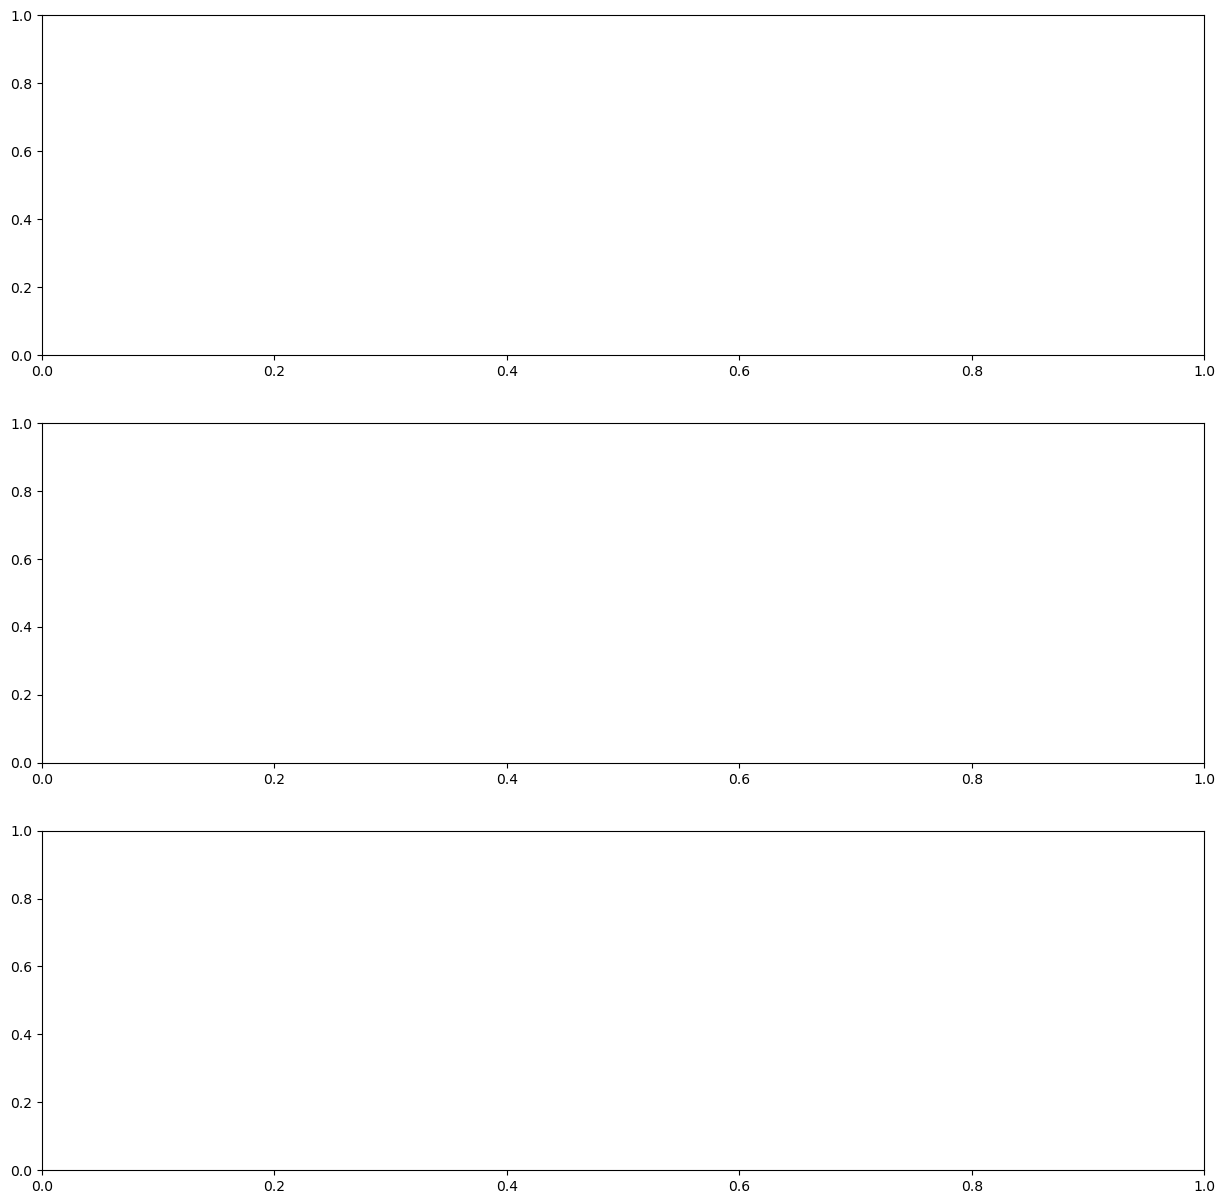

In [14]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

def calculate_features(df: pl.DataFrame, window: int = 30) -> pl.DataFrame:
    """
    Calculate aggregated features for market state identification using Polars
    """


    
    # Calculate returns by stock
    df = df.sort(['stock', 'minute']).with_columns([
        pl.col('weighted_trade_price')
        .pct_change()
        .over('stock')
        .alias('return')
    ])
    
    # Get unique timestamps
    unique_times = df.get_column('minute').unique().sort()
    
    # Process data in rolling windows
    aggregated_features = []
    
    for i in range(len(unique_times) - window + 1):
        window_start = unique_times[i]
        window_end = unique_times[i + window - 1]
        
        # Filter window data
        window_data = df.filter(
            (pl.col('minute') >= window_start) & 
            (pl.col('minute') <= window_end)
        )
        
        # Calculate window features
        features = {
            'minute': window_end,
            # Price-based features
            'avg_spread': (window_data
                         .select(pl.col('weighted_ask_price') - pl.col('weighted_bid_price'))
                         .mean()
                         .item()),
            
            'price_volatility': (window_data
                     .group_by('stock')
                     .agg(pl.col('weighted_trade_price').std())
                     .mean()
                     .get_column('weighted_trade_price')
                     .mean()),

            'return_volatility': (window_data
                      .group_by('stock')
                      .agg(pl.col('return').std())
                      .mean()
                      .get_column('return')
                      .mean()),

            'avg_return': (window_data
               .group_by('stock')
               .agg(pl.col('return').mean())
               .mean()
               .get_column('return')
               .mean()),
            
            # Volume-based features
            'avg_trade_volume': window_data.get_column('total_trade_volume').mean(),
            
            'volume_imbalance': (window_data
                                .select(pl.col('total_bid_quantity') / pl.col('total_ask_quantity'))
                                .mean()
                                .item()),

            'volume_volatility': (window_data
                      .group_by('stock')
                      .agg(pl.col('total_trade_volume').std())
                      .get_column('total_trade_volume')
                      .mean()),
            
            # Market breadth
            'advancing_stocks': (window_data
                               .group_by('stock')
                               .agg(pl.col('return').mean())
                               .filter(pl.col('return') > 0)
                               .height / window_data.get_column('stock').n_unique()),
            
            'volume_concentration': (window_data
                                   .group_by('stock')
                                   .agg(pl.col('total_trade_volume').sum())
                                   .with_columns(pl.col('total_trade_volume') / 
                                               pl.col('total_trade_volume').sum())
                                   .get_column('total_trade_volume')
                                   .std())
        }
        
        aggregated_features.append(features)
    
    return pl.DataFrame(aggregated_features)

def identify_market_states(feature_df: pl.DataFrame, n_clusters: int = 4):
    """
    Cluster market states using aggregated features
    """
    clustering_features = [
        'avg_spread', 'price_volatility', 'return_volatility',
        'avg_return', 'avg_trade_volume', 'volume_imbalance',
        'volume_volatility', 'advancing_stocks', 'volume_concentration'
    ]
    
    # Convert to numpy for sklearn
    X = feature_df.select(clustering_features).to_numpy()
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    states = kmeans.fit_predict(X_scaled)
    
    # Add states to dataframe
    feature_df = feature_df.with_columns(pl.Series(name='market_state', values=states))
    
    return feature_df, kmeans, scaler

def calculate_transition_matrix(state_df: pl.DataFrame) -> np.ndarray:
    """
    Calculate transition probabilities between market states
    """
    states = state_df.get_column('market_state').to_numpy()
    n_states = len(np.unique(states))
    
    # Initialize transition matrix
    transition_matrix = np.zeros((n_states, n_states))
    
    # Count transitions
    for i in range(len(states) - 1):
        current_state = states[i]
        next_state = states[i + 1]
        transition_matrix[current_state, next_state] += 1
    
    # Convert to probabilities
    row_sums = transition_matrix.sum(axis=1)
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]
    
    return pl.DataFrame(transition_matrix)

def analyze_market_states(feature_df: pl.DataFrame) -> pl.DataFrame:
    """
    Analyze characteristics of each market state
    """
    analysis = (feature_df
               .group_by('market_state')
               .agg([
                   pl.col('avg_spread').mean(),
                   pl.col('price_volatility').mean(),
                   pl.col('return_volatility').mean(),
                   pl.col('avg_return').mean(),
                   pl.col('avg_trade_volume').mean(),
                   pl.col('volume_imbalance').mean(),
                   pl.col('advancing_stocks').mean()
               ]))
    
    return analysis

def plot_market_states(feature_df: pl.DataFrame, transition_matrix: pl.DataFrame):
    """
    Visualize market states and transitions
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    # Convert to pandas for plotting
    feature_df_pd = feature_df.to_pandas()
    
    # Plot market states over time
    scatter = ax1.scatter(feature_df_pd['minute'], 
                         feature_df_pd['avg_return'],
                         c=feature_df_pd['market_state'],
                         cmap='viridis',
                         alpha=0.6)
    ax1.set_title('Market States Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Return')
    legend = ax1.legend(*scatter.legend_elements(), title="Market States")
    ax1.add_artist(legend)
    
    # Plot transition matrix
    sns.heatmap(transition_matrix.to_pandas(), 
                annot=True, 
                cmap='YlOrRd',
                ax=ax2)
    ax2.set_title('State Transition Probabilities')
    
    # Plot state characteristics
    state_analysis = analyze_market_states(feature_df).to_pandas()
    sns.heatmap(state_analysis.T, 
                annot=True,
                cmap='coolwarm',
                center=0,
                ax=ax3)
    ax3.set_title('Market State Characteristics')
    
    plt.tight_layout()
    plt.show()

def predict_next_state(current_state: int, transition_matrix: pl.DataFrame):
    """
    Predict the most likely next state
    """
    probabilities = transition_matrix.row(current_state)
    next_state = np.argmax(probabilities)
    return next_state, probabilities[next_state]

def main(df: pl.DataFrame, window: int = 30, n_clusters: int = 4):
    print("Calculating market features...")
    feature_df = calculate_features(df, window)


    display(feature_df.head())
    
    print("Identifying market states...")
    state_df, kmeans_model, scaler = identify_market_states(feature_df, n_clusters)
    
    print("Calculating transition probabilities...")
    transition_matrix = calculate_transition_matrix(state_df)
    
    print("\nMarket State Analysis:")
    state_analysis = analyze_market_states(state_df)
    print(state_analysis)
    
    print("\nTransition Matrix:")
    print(transition_matrix)
    
    # Predict next states
    current_state = state_df.get_column('market_state').last()
    next_state, probability = predict_next_state(current_state, transition_matrix)
    print(f"\nCurrent Market State: {current_state}")
    print(f"Predicted Next State: {next_state} (Probability: {probability:.2f})")
    
    # Visualize results
    plot_market_states(state_df, transition_matrix)
    
    return state_df, transition_matrix, kmeans_model, scaler

# Assuming df is your input DataFrame, first convert it to Polars if it's pandas
# df = pl.from_pandas(pandas_df)

# Run the analysis





state_df, transition_matrix, kmeans_model, scaler = main(pl_df)

Calculating market features...
Identifying market states...
Calculating transition probabilities...

Plotting results...


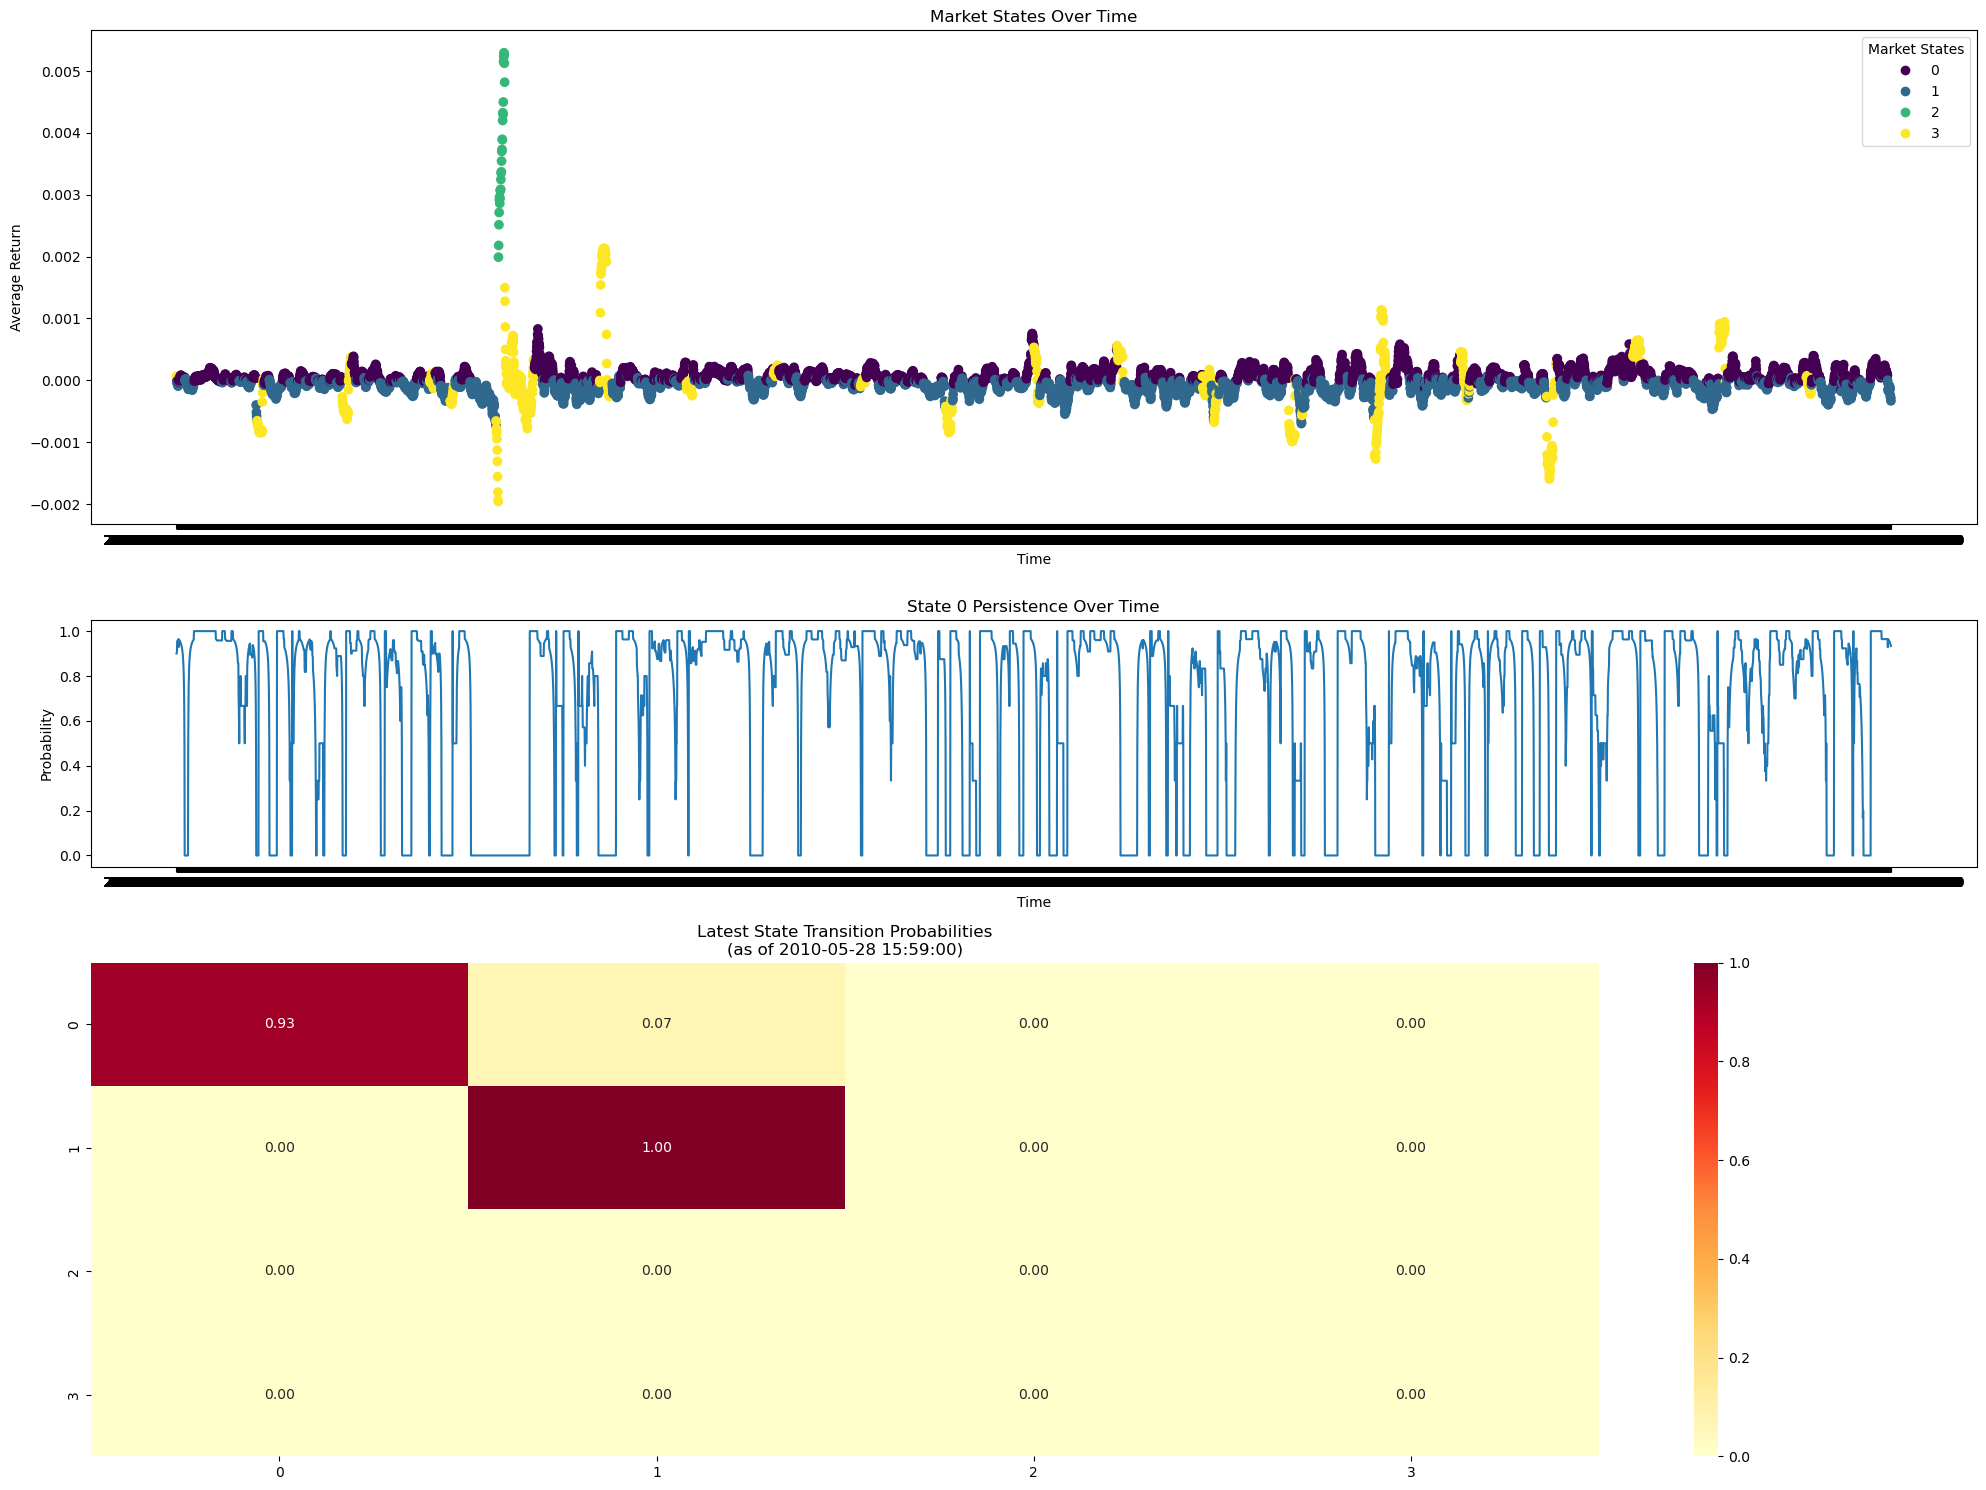


Transition Matrix Evolution Summary:
Number of transition matrices calculated: 7761

State 0 Persistence Statistics:
Mean: 0.698
Std: 0.379
Min: 0.000
Max: 1.000


In [2]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

def calculate_features(df: pl.DataFrame, window: int = 30) -> pl.DataFrame:
    """
    Calculate aggregated features for market state identification using Polars
    """
    # Add datetime column (keeping minute as is)
    df_with_datetime = df.with_columns([
        pl.col('minute')
        .str.replace('-04:00', '')
        .str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')
        .alias('datetime')
    ])
    
    # Get unique datetimes for window calculations
    datetimes = df_with_datetime.get_column('datetime').unique().sort()
    
    # Calculate window pairs
    windows = [(start, end) for start, end in zip(datetimes[:-window+1], datetimes[window-1:])]
    
    # Store results
    aggregated_features = []
    
    for window_start, window_end in windows:
        try:
            # Get window data
            window_data = df_with_datetime.filter(
                (pl.col('datetime') >= window_start) & 
                (pl.col('datetime') <= window_end)
            )
            
            # Calculate per-stock statistics
            stock_stats = (window_data
                .group_by('stock')
                .agg([
                    pl.col('weighted_trade_price').std().fill_null(0).alias('price_std'),
                    pl.col('weighted_trade_price').pct_change().mean().fill_null(0).alias('avg_return'),
                    pl.col('total_trade_volume').sum().fill_null(0).alias('total_volume'),
                    pl.col('total_trade_volume').std().fill_null(0).alias('volume_std')
                ])
            )
            
            # Get original minute string for window end
            end_minute = window_data.filter(pl.col('datetime') == window_end).get_column('minute')[0]
            
            features = {
                'minute': end_minute,
                'price_volatility': float(stock_stats.get_column('price_std').mean()),
                'return_volatility': float(stock_stats.get_column('avg_return').std()),
                'avg_return': float(stock_stats.get_column('avg_return').mean()),
                'avg_trade_volume': float(window_data.get_column('total_trade_volume').mean()),
                'volume_volatility': float(stock_stats.get_column('volume_std').mean()),
                'advancing_stocks': float(
                    (stock_stats.get_column('avg_return') > 0).sum() / len(stock_stats)
                ),
                'avg_spread': float(
                    (window_data.get_column('weighted_ask_price') - 
                     window_data.get_column('weighted_bid_price')).mean()
                )
            }
            
            # Handle null/infinite values
            features = {k: v if k == 'minute' else 0.0 if v is None or (isinstance(v, float) and not np.isfinite(v))
                       else float(v) for k, v in features.items()}
            
            aggregated_features.append(features)
            
        except Exception as e:
            print(f"Skipping window {window_start} to {window_end}: {str(e)}")
            continue
    
    if not aggregated_features:
        raise ValueError("No features could be calculated from any window")
    
    return pl.DataFrame(aggregated_features)

def identify_market_states(feature_df: pl.DataFrame, n_clusters: int = 4):
    """
    Cluster market states using aggregated features
    """
    clustering_features = [
        'price_volatility',
        'return_volatility',
        'avg_return',
        'avg_trade_volume',
        'volume_volatility',
        'advancing_stocks',
        'avg_spread'
    ]
    
    X = feature_df.select(clustering_features).to_numpy()
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    states = kmeans.fit_predict(X_scaled)
    
    feature_df = feature_df.with_columns([
        pl.Series(name='market_state', values=states)
    ])
    
    return feature_df, kmeans, scaler

def calculate_transition_matrix(state_df: pl.DataFrame, window: int = 30) -> list:
    """
    Calculate rolling transition probabilities between market states
    Returns a list of (datetime, transition_matrix) tuples
    """
    states = state_df.get_column('market_state').to_numpy()
    dates = state_df.get_column('minute').to_numpy()
    n_states = len(np.unique(states))
    
    # Store transition matrices over time
    transition_matrices = []
    
    # Calculate transition matrix for each window
    for i in range(len(states) - window):
        window_states = states[i:i+window]
        window_end_date = dates[i+window-1]
        
        # Initialize transition matrix for this window
        transition_matrix = np.zeros((n_states, n_states))
        
        # Count transitions in this window
        for j in range(len(window_states) - 1):
            from_state = window_states[j]
            to_state = window_states[j + 1]
            transition_matrix[from_state][to_state] += 1
        
        # Convert to probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = np.divide(transition_matrix, row_sums, 
                                    where=row_sums!=0, out=np.zeros_like(transition_matrix))
        
        transition_matrices.append((window_end_date, transition_matrix))
    
    return transition_matrices

def plot_results(feature_df: pl.DataFrame, transition_matrices: list):
    """
    Plot analysis results including rolling transition matrices
    """
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 2])
    
    # Plot 1: Market States Over Time
    ax1 = fig.add_subplot(gs[0])
    feature_df_pd = feature_df.to_pandas()
    scatter = ax1.scatter(feature_df_pd['minute'], 
                         feature_df_pd['avg_return'],
                         c=feature_df_pd['market_state'],
                         cmap='viridis')
    ax1.set_title('Market States Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Return')
    ax1.legend(*scatter.legend_elements(), title="Market States")
    
    # Plot 2: Transition Matrix Evolution
    ax2 = fig.add_subplot(gs[1])
    dates = [tm[0] for tm in transition_matrices]
    # Track state 0->0 transitions over time as an example
    state0_persistence = [tm[1][0,0] for tm in transition_matrices]
    ax2.plot(dates, state0_persistence, label='State 0 Persistence')
    ax2.set_title('State 0 Persistence Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Probability')
    
    # Plot 3: Latest Transition Matrix
    ax3 = fig.add_subplot(gs[2])
    latest_matrix = transition_matrices[-1][1]
    sns.heatmap(latest_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='YlOrRd',
                ax=ax3)
    ax3.set_title(f'Latest State Transition Probabilities\n(as of {dates[-1]})')
    
    plt.tight_layout()
    plt.show()
    
    # Also show some summary statistics about transition probabilities
    print("\nTransition Matrix Evolution Summary:")
    print(f"Number of transition matrices calculated: {len(transition_matrices)}")
    print("\nState 0 Persistence Statistics:")
    print(f"Mean: {np.mean(state0_persistence):.3f}")
    print(f"Std: {np.std(state0_persistence):.3f}")
    print(f"Min: {np.min(state0_persistence):.3f}")
    print(f"Max: {np.max(state0_persistence):.3f}")

def main(df: pl.DataFrame, window: int = 30, n_clusters: int = 4):
    """
    Main analysis pipeline
    """
    print("Calculating market features...")
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['weighted_trade_price', 'total_trade_volume', 
                   'weighted_ask_price', 'weighted_bid_price']
    
    df = df.with_columns([
        pl.col(col).cast(pl.Float64).fill_null(0) for col in numeric_cols
    ])
    
    feature_df = calculate_features(df, window)
    
    print("Identifying market states...")
    state_df, kmeans_model, scaler = identify_market_states(feature_df, n_clusters)
    
    print("Calculating transition probabilities...")
    transition_matrices = calculate_transition_matrix(state_df, window)
    
    print("\nPlotting results...")
    plot_results(state_df, transition_matrices)
    
    return state_df, transition_matrices, kmeans_model, scaler

df_polars = pl.from_pandas(combined_df)

# Run the analysis
state_df, transition_matrix, kmeans_model, scaler = main(df_polars)

In [12]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

def calculate_features(df: pl.DataFrame, window: int = 30) -> pl.DataFrame:
    """
    Calculate aggregated features for market state identification using Polars
    """
    # Add datetime column (keeping minute as is)
    df_with_datetime = df.with_columns([
        pl.col('minute')
        .str.replace('-04:00', '')
        .str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')
        .alias('datetime')
    ])
    
    # Get unique datetimes for window calculations
    datetimes = df_with_datetime.get_column('datetime').unique().sort()
    
    # Calculate window pairs
    windows = [(start, end) for start, end in zip(datetimes[:-window+1], datetimes[window-1:])]
    
    # Store results
    aggregated_features = []
    
    for window_start, window_end in windows:
        try:
            # Get window data
            window_data = df_with_datetime.filter(
                (pl.col('datetime') >= window_start) & 
                (pl.col('datetime') <= window_end)
            )
            
            # Calculate per-stock statistics
            stock_stats = (window_data
                .group_by('stock')
                .agg([
                    pl.col('weighted_trade_price').std().fill_null(0).alias('price_std'),
                    pl.col('weighted_trade_price').pct_change().mean().fill_null(0).alias('avg_return'),
                    pl.col('total_trade_volume').sum().fill_null(0).alias('total_volume'),
                    pl.col('total_trade_volume').std().fill_null(0).alias('volume_std')
                ])
            )
            
            # Get original minute string for window end
            end_minute = window_data.filter(pl.col('datetime') == window_end).get_column('minute')[0]
            
            features = {
                'minute': end_minute,
                'price_volatility': float(stock_stats.get_column('price_std').mean()),
                'return_volatility': float(stock_stats.get_column('avg_return').std()),
                'avg_return': float(stock_stats.get_column('avg_return').mean()),
                'avg_trade_volume': float(window_data.get_column('total_trade_volume').mean()),
                'volume_volatility': float(stock_stats.get_column('volume_std').mean()),
                'advancing_stocks': float(
                    (stock_stats.get_column('avg_return') > 0).sum() / len(stock_stats)
                ),
                'avg_spread': float(
                    (window_data.get_column('weighted_ask_price') - 
                     window_data.get_column('weighted_bid_price')).mean()
                )
            }
            
            # Handle null/infinite values
            features = {k: v if k == 'minute' else 0.0 if v is None or (isinstance(v, float) and not np.isfinite(v))
                       else float(v) for k, v in features.items()}
            
            aggregated_features.append(features)
            
        except Exception as e:
            print(f"Skipping window {window_start} to {window_end}: {str(e)}")
            continue
    
    if not aggregated_features:
        raise ValueError("No features could be calculated from any window")
    
    return pl.DataFrame(aggregated_features)

def identify_market_states(feature_df: pl.DataFrame, n_clusters: int = 4):
    """
    Cluster market states using aggregated features
    """
    clustering_features = [
        'price_volatility',
        'return_volatility',
        'avg_return',
        'avg_trade_volume',
        'volume_volatility',
        'advancing_stocks',
        'avg_spread'
    ]
    
    X = feature_df.select(clustering_features).to_numpy()
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    states = kmeans.fit_predict(X_scaled)
    
    feature_df = feature_df.with_columns([
        pl.Series(name='market_state', values=states)
    ])
    
    return feature_df, kmeans, scaler

def calculate_transition_matrix(state_df: pl.DataFrame, window: int = 30) -> list:
    """
    Calculate rolling transition probabilities between market states
    Returns a list of (datetime, transition_matrix) tuples
    """
    states = state_df.get_column('market_state').to_numpy()
    dates = state_df.get_column('minute').to_numpy()
    n_states = len(np.unique(states))
    
    # Store transition matrices over time
    transition_matrices = []
    
    # Calculate transition matrix for each window
    for i in range(len(states) - window):
        window_states = states[i:i+window]
        window_end_date = dates[i+window-1]
        
        # Initialize transition matrix for this window
        transition_matrix = np.zeros((n_states, n_states))
        
        # Count transitions in this window
        for j in range(len(window_states) - 1):
            from_state = window_states[j]
            to_state = window_states[j + 1]
            transition_matrix[from_state][to_state] += 1
        
        # Convert to probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = np.divide(transition_matrix, row_sums, 
                                    where=row_sums!=0, out=np.zeros_like(transition_matrix))
        
        transition_matrices.append((window_end_date, transition_matrix))
    
    return transition_matrices

def plot_results(feature_df: pl.DataFrame, transition_matrices: list):
    """
    Plot analysis results including rolling transition matrices
    """
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 2])
    
    # Plot 1: Market States Over Time
    ax1 = fig.add_subplot(gs[0])
    feature_df_pd = feature_df.to_pandas()
    scatter = ax1.scatter(feature_df_pd['minute'], 
                         feature_df_pd['avg_return'],
                         c=feature_df_pd['market_state'],
                         cmap='viridis')
    ax1.set_title('Market States Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Return')
    ax1.legend(*scatter.legend_elements(), title="Market States")
    
    # Plot 2: Transition Matrix Evolution
    ax2 = fig.add_subplot(gs[1])
    dates = [tm[0] for tm in transition_matrices]
    # Track state 0->0 transitions over time as an example
    state0_persistence = [tm[1][0,0] for tm in transition_matrices]
    ax2.plot(dates, state0_persistence, label='State 0 Persistence')
    ax2.set_title('State 0 Persistence Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Probability')
    
    # Plot 3: Latest Transition Matrix
    ax3 = fig.add_subplot(gs[2])
    latest_matrix = transition_matrices[-1][1]
    sns.heatmap(latest_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='YlOrRd',
                ax=ax3)
    ax3.set_title(f'Latest State Transition Probabilities\n(as of {dates[-1]})')
    
    plt.tight_layout()
    plt.show()
    
    # Also show some summary statistics about transition probabilities
    print("\nTransition Matrix Evolution Summary:")
    print(f"Number of transition matrices calculated: {len(transition_matrices)}")
    print("\nState 0 Persistence Statistics:")
    print(f"Mean: {np.mean(state0_persistence):.3f}")
    print(f"Std: {np.std(state0_persistence):.3f}")
    print(f"Min: {np.min(state0_persistence):.3f}")
    print(f"Max: {np.max(state0_persistence):.3f}")

def analyze_states(state_df: pl.DataFrame, n_clusters: int = 4):
    """
    Analyze characteristics of each market state
    """
    state_stats = []
    
    for state in range(n_clusters):
        state_data = state_df.filter(pl.col('market_state') == state)
        
        stats = {
            'state': state,
            'avg_return': float(state_data.get_column('avg_return').mean()),
            'return_volatility': float(state_data.get_column('return_volatility').mean()),
            'price_volatility': float(state_data.get_column('price_volatility').mean()),
            'volume_volatility': float(state_data.get_column('volume_volatility').mean()),
            'avg_volume': float(state_data.get_column('avg_trade_volume').mean()),
            'avg_spread': float(state_data.get_column('avg_spread').mean()),
            'advancing_stocks': float(state_data.get_column('advancing_stocks').mean()),
            'frequency': len(state_data) / len(state_df)
        }
        
        state_stats.append(stats)
    
    # Convert to DataFrame for better display
    stats_df = pl.DataFrame(state_stats)
    
    # Print analysis and trading strategies
    print("\nMarket State Analysis and Trading Strategies:")
    print("============================================")
    
    for state in range(n_clusters):
        stats = stats_df.filter(pl.col('state') == state).to_dicts()[0]
        
        print(f"\nState {state}:")
        print(f"Frequency: {stats['frequency']*100:.1f}% of time")
        print(f"Average Return: {stats['avg_return']*100:.3f}%")
        print(f"Return Volatility: {stats['return_volatility']:.4f}")
        print(f"Price Volatility: {stats['price_volatility']:.4f}")
        print(f"Average Volume: {stats['avg_volume']:.0f}")
        print(f"Average Spread: {stats['avg_spread']:.4f}")
        print(f"Advancing Stocks: {stats['advancing_stocks']*100:.1f}%")
        
        print("\nCharacteristics:")
        if stats['avg_return'] > 0.001:
            trend = "Bullish"
        elif stats['avg_return'] < -0.001:
            trend = "Bearish"
        else:
            trend = "Neutral"
            
        if stats['return_volatility'] > stats_df['return_volatility'].mean():
            volatility = "High"
        else:
            volatility = "Low"
            
        if stats['avg_volume'] > stats_df['avg_volume'].mean():
            volume = "High"
        else:
            volume = "Low"
            
        print(f"- Trend: {trend}")
        print(f"- Volatility: {volatility}")
        print(f"- Volume: {volume}")
        
        print("\nRecommended Strategy:")
        if trend == "Bullish" and volatility == "Low":
            print("- Long positions with trend following")
            print("- Use moderate leverage")
            print("- Set wider stops due to positive trend")
        elif trend == "Bullish" and volatility == "High":
            print("- Selective long positions")
            print("- Reduce position sizes")
            print("- Tighter stops due to volatility")
        elif trend == "Bearish" and volatility == "Low":
            print("- Short positions with trend following")
            print("- Use moderate leverage")
            print("- Set wider stops due to clear trend")
        elif trend == "Bearish" and volatility == "High":
            print("- Selective short positions")
            print("- Reduce position sizes")
            print("- Tighter stops due to volatility")
        else:  # Neutral
            if volatility == "High":
                print("- Range trading strategies")
                print("- Focus on mean reversion")
                print("- Quick profit taking")
            else:
                print("- Stay in cash or minimal exposure")
                print("- Wait for clearer signals")
                print("- Focus on capital preservation")
                
    return stats_df

def main(df: pl.DataFrame, window: int = 30, n_clusters: int = 4):
    """
    Main analysis pipeline
    """
    print("Calculating market features...")
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['weighted_trade_price', 'total_trade_volume', 
                   'weighted_ask_price', 'weighted_bid_price']
    
    df = df.with_columns([
        pl.col(col).cast(pl.Float64).fill_null(0) for col in numeric_cols
    ])
    
    feature_df = calculate_features(df, window)
    
    print("Identifying market states...")
    state_df, kmeans_model, scaler = identify_market_states(feature_df, n_clusters)
    
    print("Calculating transition probabilities...")
    transition_matrices = calculate_transition_matrix(state_df, window)
    
    print("Analyzing market states...")
    state_stats = analyze_states(state_df, n_clusters)
    
    print("\nPlotting results...")
    plot_results(state_df, transition_matrices)
    
    return state_df, transition_matrices, kmeans_model, scaler, state_stats

state_df, transition_matrices, kmeans_model, scaler, state_stats = main(df_polars)

Calculating market features...
Identifying market states...
Calculating transition probabilities...
Analyzing market states...

Market State Analysis and Trading Strategies:

State 0:
Frequency: 45.7% of time
Average Return: 0.011%
Return Volatility: 0.0004
Price Volatility: 0.0877
Average Volume: 66337
Average Spread: 0.0281
Advancing Stocks: 74.2%

Characteristics:
- Trend: Neutral
- Volatility: Low
- Volume: Low

Recommended Strategy:
- Stay in cash or minimal exposure
- Wait for clearer signals
- Focus on capital preservation

State 1:
Frequency: 43.2% of time
Average Return: -0.012%
Return Volatility: 0.0004
Price Volatility: 0.0920
Average Volume: 68708
Average Spread: 0.0280
Advancing Stocks: 22.5%

Characteristics:
- Trend: Neutral
- Volatility: Low
- Volume: Low

Recommended Strategy:
- Stay in cash or minimal exposure
- Wait for clearer signals
- Focus on capital preservation

State 2:
Frequency: 0.4% of time
Average Return: 0.370%
Return Volatility: 0.0408
Price Volatility: 

KeyboardInterrupt: 

In [5]:
state_df.head()

minute,price_volatility,return_volatility,avg_return,avg_trade_volume,volume_volatility,advancing_stocks,avg_spread,market_state
str,f64,f64,f64,f64,f64,f64,f64,i32
"""2010-05-03 09:59:00""",0.166642,0.000545,0.000066,126962.690965,115851.259601,0.606061,0.056145,3
"""2010-05-03 10:00:00""",0.158443,0.000421,0.000051,116052.49692,106981.056412,0.560606,0.051642,3
"""2010-05-03 10:01:00""",0.15142,0.000457,-0.000015,112777.992727,104696.721105,0.530303,0.04879,0
"""2010-05-03 10:02:00""",0.142366,0.000432,-0.00004,104478.306122,99298.478415,0.5,0.048154,1
"""2010-05-03 10:03:00""",0.139005,0.000425,-0.000051,98313.933408,97242.969674,0.44697,0.04604,1


,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock
0,2010-05-03 09:30:00,58.960000,6,35.0,59.065455,11,2.0,59.030000,1200,2010-05-03,NaN,NaN,NaN,DLR
1,2010-05-03 09:32:00,59.028846,5,26.0,59.143333,12,2.0,59.103284,1218,2010-05-03,2.0,0.001241,0.000621,DLR
2,2010-05-03 09:33:00,59.304444,4,9.0,59.555000,10,3.0,59.518000,500,2010-05-03,1.0,0.007017,0.007017,DLR
3,2010-05-03 09:34:00,59.560000,1,2.0,59.660000,4,2.0,59.560000,400,2010-05-03,1.0,0.000706,0.000706,DLR
4,2010-05-03 09:35:00,59.570000,1,1.0,59.710000,5,5.0,59.680000,100,2010-05-03,1.0,0.002015,0.002015,DLR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921553,2010-05-28 15:56:00,16.002350,363,15740.0,16.018104,31397,336.0,16.008182,45100,2010-05-28,1.0,-0.002064,-0.002064,DUK
921554,2010-05-28 15:57:00,15.966723,497,28312.0,15.981054,35861,309.0,15.974313,115409,2010-05-28,1.0,-0.002116,-0.002116,DUK
921555,2010-05-28 15:58:00,15.956163,537,41007.0,15.967959,45655,339.0,15.962712,39802,2010-05-28,1.0,-0.000726,-0.000726,DUK
921556,2010-05-28 15:59:00,15.947064,659,186297.0,15.958776,157683,2315.0,15.953423,205520,2010-05-28,1.0,-0.000582,-0.000582,DUK


In [19]:
#AGGREGRATE FEATURES PER STATE
combined_df = combined_df.astype({'minute': 'str', 'stock': 'str'})
cdf = pd.merge(combined_df, state_df.to_pandas()[['minute', 'market_state']], on='minute')
cdf

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock,market_state
0,2010-05-03 10:00:00,59.627500,3,12.0,59.643750,8,2.0,59.637500,800,2010-05-03,2.0,-0.000042,-0.000021,DLR,3
1,2010-05-03 10:01:00,59.569231,3,13.0,59.616000,10,4.0,59.588333,600,2010-05-03,1.0,-0.000824,-0.000824,DLR,0
2,2010-05-03 10:02:00,59.604286,6,28.0,59.633333,12,2.0,59.610000,1500,2010-05-03,1.0,0.000364,0.000364,DLR,1
3,2010-05-03 10:03:00,59.597766,5,94.0,59.669143,105,9.0,59.651111,3600,2010-05-03,1.0,0.000690,0.000690,DLR,1
4,2010-05-03 10:04:00,59.576000,6,25.0,59.652500,16,7.0,59.601872,812,2010-05-03,1.0,-0.000825,-0.000825,DLR,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918114,2010-05-28 15:56:00,16.002350,363,15740.0,16.018104,31397,336.0,16.008182,45100,2010-05-28,1.0,-0.002064,-0.002064,DUK,1
918115,2010-05-28 15:57:00,15.966723,497,28312.0,15.981054,35861,309.0,15.974313,115409,2010-05-28,1.0,-0.002116,-0.002116,DUK,1
918116,2010-05-28 15:58:00,15.956163,537,41007.0,15.967959,45655,339.0,15.962712,39802,2010-05-28,1.0,-0.000726,-0.000726,DUK,1
918117,2010-05-28 15:59:00,15.947064,659,186297.0,15.958776,157683,2315.0,15.953423,205520,2010-05-28,1.0,-0.000582,-0.000582,DUK,1


In [20]:
# Group by stock for analysis
stock_stats = cdf.groupby('stock').agg({
        'total_trade_volume': ['mean', 'max', 'min', 'sum'],
        'weighted_trade_price': ['mean', 'max', 'min', 'std'],
        'minute': 'count'
    }).round(2)
    
    # Calculate volatility
stock_stats['price_volatility'] = (
        stock_stats[('weighted_trade_price', 'max')] - 
        stock_stats[('weighted_trade_price', 'min')]
)
most_volatile = stock_stats['price_volatility'].idxmax()													# Instead of using .loc with complex indexing, let's get the values directly
volatility = stock_stats.loc[most_volatile, ('price_volatility', '')]

In [39]:
cdf_bh = cdf[cdf['stock'] == 'C']

In [40]:
cdf_bh

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock,market_state
383850,2010-05-03 09:59:00,4.410000,11652,635211.0,4.420000,433895,8337.0,4.416044,104536,2010-05-03,1.0,-0.000346,-0.000346,C,3
383851,2010-05-03 10:00:00,4.410000,10448,214197.0,4.420000,138924,7033.0,4.419299,54532,2010-05-03,1.0,0.000737,0.000737,C,3
383852,2010-05-03 10:01:00,4.410000,10366,2890446.0,4.420000,2891012,9333.0,4.410203,1503720,2010-05-03,1.0,-0.002058,-0.002058,C,0
383853,2010-05-03 10:02:00,4.410000,10474,508405.0,4.420000,434676,10912.0,4.414488,63260,2010-05-03,1.0,0.000971,0.000971,C,1
383854,2010-05-03 10:03:00,4.410000,9225,425502.0,4.420000,565763,12637.0,4.416223,79562,2010-05-03,1.0,0.000393,0.000393,C,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391627,2010-05-28 15:56:00,3.980000,29912,4169252.0,3.990000,4611622,33113.0,3.980772,344743,2010-05-28,1.0,-0.002322,-0.002322,C,1
391628,2010-05-28 15:57:00,3.974518,30427,19830994.0,3.987867,42326509,47231.0,3.980009,5123115,2010-05-28,1.0,-0.000192,-0.000192,C,1
391629,2010-05-28 15:58:00,3.970000,29405,8172412.0,3.980000,9649727,33659.0,3.970628,1046714,2010-05-28,1.0,-0.002357,-0.002357,C,1
391630,2010-05-28 15:59:00,3.964829,31203,30834831.0,3.975944,63073886,45650.0,3.968887,12629812,2010-05-28,1.0,-0.000438,-0.000438,C,1


,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock,market_state
384993,2010-05-06 09:30:00,4.203050,9766,5363245.0,4.213444,7327185,7468.0,4.215830,36714209,2010-05-06,1.0,0.003769,0.003769,C,1
384994,2010-05-06 09:31:00,4.195588,7987,2660292.0,4.205566,7335589,10072.0,4.199746,6316248,2010-05-06,1.0,-0.003815,-0.003815,C,1
384995,2010-05-06 09:32:00,4.184398,8324,6699714.0,4.193364,12673514,24168.0,4.189970,7732421,2010-05-06,1.0,-0.002328,-0.002328,C,1
384996,2010-05-06 09:33:00,4.183638,9227,13705852.0,4.194840,13523225,11475.0,4.190035,19409940,2010-05-06,1.0,0.000016,0.000016,C,1
384997,2010-05-06 09:34:00,4.190000,7107,786684.0,4.200000,964092,8357.0,4.196550,342669,2010-05-06,1.0,0.001555,0.001555,C,1


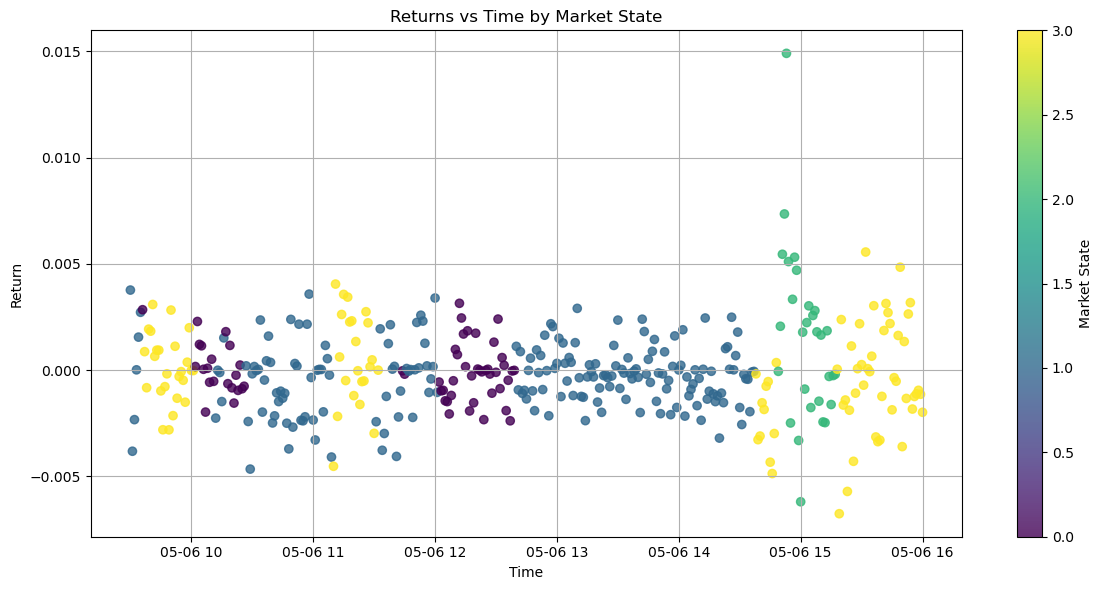

In [41]:
# Convert the 'minute' column to a datetime object for plotting
cdf_bh["minute"] = pd.to_datetime(cdf_bh["minute"])
#I want only minutes in the 6 may
cdf_bh = cdf_bh[cdf_bh["minute"].dt.date == pd.Timestamp("2010-05-06").date()]

display(cdf_bh.head())

# Plot returns vs time, color-coded by market_state
plt.figure(figsize=(12, 6))
scatter = plt.scatter(
    cdf_bh["minute"], cdf_bh["return"], c=cdf_bh["market_state"], cmap="viridis", alpha=0.8
)
plt.colorbar(scatter, label="Market State")
plt.title("Returns vs Time by Market State")
plt.xlabel("Time")
plt.ylabel("Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#TODO
#LIRE GITHUB 
# CREER NOS TRANSITONS MATRIXES AVEC CE QUE GHALIA A ENVOYé 
# CREER LES STRATEGIES DE TRADING
#BACKTEST AVEC UNE DATE ARBITRAIRE
#A DES FINS D'ANALYSE , CHECK LES STOCKS AVEC DES BETAS PLUS OU MOINS ELEVES LE 6 MAI (JOUR DU CRASH) POUR VOIR SI LA TENDANCE EST LA MEME QUE CELLE DU MARKET
#(HIGH BETA, STOCKS WITH HIGH TRADING VOLUME, STOCKS WITH HIGH VOLATILITY)


In [ ]:
combined_df= 

In [22]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


Calculating market features...
Identifying market states...
Calculating transition probabilities...

Plotting results...


ModuleNotFoundError: pa.Table requires 'pyarrow' module to be installed

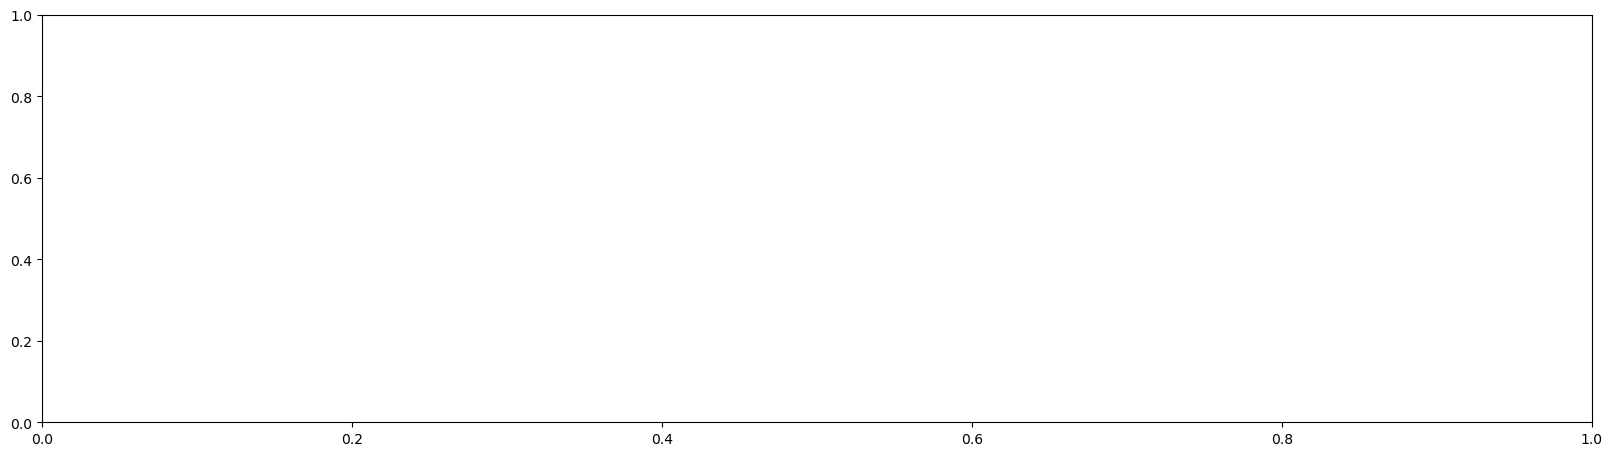

In [21]:
import polars as pl
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

def calculate_features(df: pl.DataFrame, window: int = 30) -> pl.DataFrame:
    """
    Calculate aggregated features for market state identification using Polars
    """
    # Add datetime column (keeping minute as is)
    df_with_datetime = df.with_columns([
        pl.col('minute')
        .str.replace('-04:00', '')
        .str.strptime(pl.Datetime, '%Y-%m-%d %H:%M:%S')
        .alias('datetime')
    ])
    
    # Get unique datetimes for window calculations
    datetimes = df_with_datetime.get_column('datetime').unique().sort()
    
    # Calculate window pairs
    windows = [(start, end) for start, end in zip(datetimes[:-window+1], datetimes[window-1:])]
    
    # Store results
    aggregated_features = []
    
    for window_start, window_end in windows:
        try:
            # Get window data
            window_data = df_with_datetime.filter(
                (pl.col('datetime') >= window_start) & 
                (pl.col('datetime') <= window_end)
            )
            
            # Calculate per-stock statistics
            stock_stats = (window_data
                .group_by('stock')
                .agg([
                    pl.col('weighted_trade_price').std().fill_null(0).alias('price_std'),
                    pl.col('weighted_trade_price').pct_change().mean().fill_null(0).alias('avg_return'),
                    pl.col('total_trade_volume').sum().fill_null(0).alias('total_volume'),
                    pl.col('total_trade_volume').std().fill_null(0).alias('volume_std')
                ])
            )
            
            # Get original minute string for window end
            end_minute = window_data.filter(pl.col('datetime') == window_end).get_column('minute')[0]
            
            features = {
                'minute': end_minute,
                'price_volatility': float(stock_stats.get_column('price_std').mean()),
                'return_volatility': float(stock_stats.get_column('avg_return').std()),
                'avg_return': float(stock_stats.get_column('avg_return').mean()),
                'avg_trade_volume': float(window_data.get_column('total_trade_volume').mean()),
                'volume_volatility': float(stock_stats.get_column('volume_std').mean()),
                'advancing_stocks': float(
                    (stock_stats.get_column('avg_return') > 0).sum() / len(stock_stats)
                ),
                'avg_spread': float(
                    (window_data.get_column('weighted_ask_price') - 
                     window_data.get_column('weighted_bid_price')).mean()
                )
            }
            
            # Handle null/infinite values
            features = {k: v if k == 'minute' else 0.0 if v is None or (isinstance(v, float) and not np.isfinite(v))
                       else float(v) for k, v in features.items()}
            
            aggregated_features.append(features)
            
        except Exception as e:
            print(f"Skipping window {window_start} to {window_end}: {str(e)}")
            continue
    
    if not aggregated_features:
        raise ValueError("No features could be calculated from any window")
    
    return pl.DataFrame(aggregated_features)

def identify_market_states(feature_df: pl.DataFrame, n_clusters: int = 4):
    """
    Cluster market states using aggregated features
    """
    clustering_features = [
        'price_volatility',
        'return_volatility',
        'avg_return',
        'avg_trade_volume',
        'volume_volatility',
        'advancing_stocks',
        'avg_spread'
    ]
    
    X = feature_df.select(clustering_features).to_numpy()
    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    states = kmeans.fit_predict(X_scaled)
    
    feature_df = feature_df.with_columns([
        pl.Series(name='market_state', values=states)
    ])
    
    return feature_df, kmeans, scaler

def calculate_transition_matrix(state_df: pl.DataFrame, window: int = 30) -> list:
    """
    Calculate rolling transition probabilities between market states
    Returns a list of (datetime, transition_matrix) tuples
    """
    states = state_df.get_column('market_state').to_numpy()
    dates = state_df.get_column('minute').to_numpy()
    n_states = len(np.unique(states))
    
    # Store transition matrices over time
    transition_matrices = []
    
    # Calculate transition matrix for each window
    for i in range(len(states) - window):
        window_states = states[i:i+window]
        window_end_date = dates[i+window-1]
        
        # Initialize transition matrix for this window
        transition_matrix = np.zeros((n_states, n_states))
        
        # Count transitions in this window
        for j in range(len(window_states) - 1):
            from_state = window_states[j]
            to_state = window_states[j + 1]
            transition_matrix[from_state][to_state] += 1
        
        # Convert to probabilities
        row_sums = transition_matrix.sum(axis=1, keepdims=True)
        transition_matrix = np.divide(transition_matrix, row_sums, 
                                    where=row_sums!=0, out=np.zeros_like(transition_matrix))
        
        transition_matrices.append((window_end_date, transition_matrix))
    
    return transition_matrices

def plot_results(feature_df: pl.DataFrame, transition_matrices: list):
    """
    Plot analysis results including rolling transition matrices
    """
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 2])
    
    # Plot 1: Market States Over Time
    ax1 = fig.add_subplot(gs[0])
    feature_df_pd = feature_df.to_pandas()
    scatter = ax1.scatter(feature_df_pd['minute'], 
                         feature_df_pd['avg_return'],
                         c=feature_df_pd['market_state'],
                         cmap='viridis')
    ax1.set_title('Market States Over Time')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Average Return')
    ax1.legend(*scatter.legend_elements(), title="Market States")
    
    # Plot 2: Transition Matrix Evolution
    ax2 = fig.add_subplot(gs[1])
    dates = [tm[0] for tm in transition_matrices]
    # Track state 0->0 transitions over time as an example
    state0_persistence = [tm[1][0,0] for tm in transition_matrices]
    ax2.plot(dates, state0_persistence, label='State 0 Persistence')
    ax2.set_title('State 0 Persistence Over Time')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Probability')
    
    # Plot 3: Latest Transition Matrix
    ax3 = fig.add_subplot(gs[2])
    latest_matrix = transition_matrices[-1][1]
    sns.heatmap(latest_matrix, 
                annot=True, 
                fmt='.2f',
                cmap='YlOrRd',
                ax=ax3)
    ax3.set_title(f'Latest State Transition Probabilities\n(as of {dates[-1]})')
    
    plt.tight_layout()
    plt.show()
    
    # Also show some summary statistics about transition probabilities
    print("\nTransition Matrix Evolution Summary:")
    print(f"Number of transition matrices calculated: {len(transition_matrices)}")
    print("\nState 0 Persistence Statistics:")
    print(f"Mean: {np.mean(state0_persistence):.3f}")
    print(f"Std: {np.std(state0_persistence):.3f}")
    print(f"Min: {np.min(state0_persistence):.3f}")
    print(f"Max: {np.max(state0_persistence):.3f}")

def main(df: pl.DataFrame, window: int = 30, n_clusters: int = 4):
    """
    Main analysis pipeline
    """
    print("Calculating market features...")
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['weighted_trade_price', 'total_trade_volume', 
                   'weighted_ask_price', 'weighted_bid_price']
    
    df = df.with_columns([
        pl.col(col).cast(pl.Float64).fill_null(0) for col in numeric_cols
    ])
    
    feature_df = calculate_features(df, window)
    
    print("Identifying market states...")
    state_df, kmeans_model, scaler = identify_market_states(feature_df, n_clusters)
    
    print("Calculating transition probabilities...")
    transition_matrices = calculate_transition_matrix(state_df, window)
    
    print("\nPlotting results...")
    plot_results(state_df, transition_matrices)
    
    return state_df, transition_matrices, kmeans_model, scaler

df_polars = pl.from_pandas(combined_df)

# Run the analysis
state_df, transition_matrix, kmeans_model, scaler = main(df_polars)

In [42]:
#print the type of each variable of combined_df
for column in combined_df.columns:
    print(f"{column}: {type(combined_df[column][0])}")


minute: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
weighted_bid_price: <class 'numpy.float64'>
max_bid_quantity: <class 'numpy.int32'>
total_bid_quantity: <class 'numpy.float64'>
weighted_ask_price: <class 'numpy.float64'>
total_ask_quantity: <class 'numpy.int32'>
max_ask_quantity: <class 'numpy.float64'>
weighted_trade_price: <class 'numpy.float64'>
total_trade_volume: <class 'numpy.int32'>
date: <class 'str'>
delta_time: <class 'numpy.float64'>
return: <class 'numpy.float64'>
normalized_return: <class 'numpy.float64'>
stock: <class 'str'>
